# Imports

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define paths / download files

In [ ]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
  BASE_PATH = '/content/rna-llm-folding'
  RESULTS_PATH = f"{BASE_PATH}/results"
  !git clone https://github.com/sinc-lab/rna-llm-folding.git
else:
  BASE_PATH = '../' # o ./
  RESULTS_PATH = f"{BASE_PATH}/results"
  import os
  if not os.path.isdir(f'{RESULTS_PATH}'):
    raise Exception('results folder not found, download it from https://github.com/sinc-lab/rna-llm-folding')


Cloning into 'rna-llm-folding'...
remote: Enumerating objects: 753, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 753 (delta 19), reused 45 (delta 10), pack-reused 698 (from 1)
Receiving objects: 100% (753/753), 66.17 MiB | 11.08 MiB/s, done.
Resolving deltas: 100% (227/227), done.
Updating files: 100% (591/591), done.


# Define colors

In [ ]:
llm_colors={
    'RNA-FM': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    'RiNALMo': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    'RNABERT': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    'RNAErnie': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    'one-hot': 'lightgrey', # '(.8, .8, .8, 1)',
    'ERNIE-RNA': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
    'RNA-MSM': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
}

# Fig parameters

In [ ]:
from matplotlib import rcParams

w = 4.6 # figure width in inches
h = 4.6 # figure height in inches
fs = 6  # font size
fs_labels = 5 # font size of labels

# Common methods

In [ ]:
def reduce_dataframe(df, percentage):
  """Reduces a dataframe by a given percentage, randomly selecting rows within each LLM group.

  Args:
    df: The input dataframe.
    percentage: The percentage of data to remove (e.g., 0.1 for 10%).

  Returns:
    The reduced dataframe.
  """
  # Create a copy of the dataframe to avoid modifying the original
  reduced_df = df.copy()

  # Calculate the number of rows to remove for each LLM group
  group_sizes = reduced_df.groupby('LLM').size()
  rows_to_remove = (percentage * group_sizes).astype(int)

  # Randomly select rows to remove for each LLM group
  for l in rows_to_remove.index:
    group = reduced_df[reduced_df['LLM'] == l]
    sample_indices = group.sample(n=rows_to_remove[l],random_state=42).index
    reduced_df = reduced_df.drop(sample_indices)
  return reduced_df

In [ ]:
def plot(df, baseline_median, write_fig_path,perc_to_remove=None):
  plt.rc('axes', edgecolor='gray')
  plt.rcParams.update({'font.size': fs, 'figure.figsize': [w/2.54, h/2.54]})
  sns.set_style("whitegrid")

  medians = df.groupby(['LLM']).median()
  sorted_df = medians.sort_values(by='F1', ascending=False)
  facetgrid = sns.violinplot(
      data=df, x="LLM", y="F1", hue="LLM",
      inner=None, palette=llm_colors,order=sorted_df.index,
      fill=False,linewidth=0.75,alpha=.5
  )
  facetgrid.axhline(baseline_median, 0, 1,color='dodgerblue',linewidth=0.75,zorder=0)
  # facetgrid.fig.set_size_inches()
  facetgrid.set_xticklabels(facetgrid.get_xticklabels(), fontsize=fs_labels,rotation=45)

  sns.swarmplot(data=reduce_dataframe(df, perc_to_remove) if perc_to_remove else df, x="LLM", y="F1", s=1.05, hue="LLM", palette=llm_colors,)
  facetgrid.set(xlabel=None)
  facetgrid.set(ylabel="F1 score")

  facetgrid.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  facetgrid.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=fs_labels)

  facetgrid.set(ylim=[0, 1])
  facetgrid.tick_params(axis='x', pad=0)  # 7)
  facetgrid.tick_params(axis='y', pad=0)
  facetgrid.scatter(x=range(len(sorted_df['F1'])),y=sorted_df['F1'],c="k",s=2,marker="*",zorder=100)
  facetgrid.grid(True, axis='y')

  plt.tight_layout()

  plt.savefig(write_fig_path, format="svg")


# Read baseline medians

In [ ]:
baseline_medians = pd.read_csv(f"{RESULTS_PATH}/baseline_medians.csv")

In [ ]:
baseline_medians

,medianF1,dataset
0,0.666667,ArchiveII
1,0.595238,bpRNA
2,0.709677,bpRNA_new
3,0.683956,pdb-rna


In [ ]:
baseline_median_kfold = baseline_medians.loc[baseline_medians['dataset'] == 'ArchiveII']['medianF1'].item()
baseline_median_bpRNA = baseline_medians.loc[baseline_medians['dataset'] == 'bpRNA']['medianF1'].item()
baseline_median_bpRNA_new = baseline_medians.loc[baseline_medians['dataset'] == 'bpRNA_new']['medianF1'].item()
baseline_median_pdb = baseline_medians.loc[baseline_medians['dataset'] == 'pdb-rna']['medianF1'].item()

# plot kfold

In [ ]:
kfold_df = pd.read_csv(f"{RESULTS_PATH}/all_kfold.csv")

<ipython-input-6-67600bc38115>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  facetgrid.set_xticklabels(facetgrid.get_xticklabels(), fontsize=fs_labels,rotation=45)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 36.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 34.5% of the points cannot be placed; you may want to dec

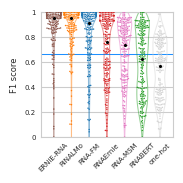

In [ ]:
plot(kfold_df, baseline_median_kfold, "kfold.svg", .95) # K=150

# plot bpRNA

In [ ]:
bprna_df = pd.read_csv(f"{RESULTS_PATH}/all_bpRNA.csv")

<ipython-input-6-67600bc38115>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  facetgrid.set_xticklabels(facetgrid.get_xticklabels(), fontsize=fs_labels,rotation=45)


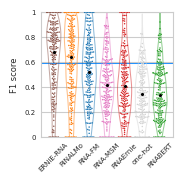

In [ ]:
plot(bprna_df, baseline_median_bpRNA, "bpRNA.svg", .85) # K=200

# plot bpRNA new

In [ ]:
bprna_new_df = pd.read_csv(f"{RESULTS_PATH}/all_bpRNA_new.csv")

<ipython-input-6-67600bc38115>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  facetgrid.set_xticklabels(facetgrid.get_xticklabels(), fontsize=fs_labels,rotation=45)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


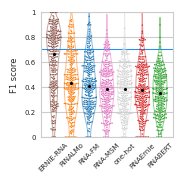

In [ ]:
plot(bprna_new_df, baseline_median_bpRNA_new, "bpRNA_new.svg", .95) # K=200

# plot PDB-RNA

In [ ]:
pdb_df = pd.read_csv(f"{RESULTS_PATH}/all_pdb.csv")

<ipython-input-6-67600bc38115>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  facetgrid.set_xticklabels(facetgrid.get_xticklabels(), fontsize=fs_labels,rotation=45)


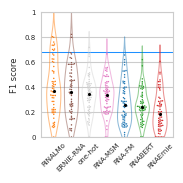

In [ ]:
plot(pdb_df, baseline_median_pdb, "pdb.svg")